In [1]:
# Peri 12/3/24 adopted and re-writtenn using biopython
# inspired by the excellent work of Aravind CR (neptune.ai MLOps blog)
!pip install biopython
!pip install -U spacy
!pip install tqdm

In [2]:
from Bio import Entrez
import pandas as pd
import numpy as np

In [3]:
def search(query):
    # Set the email address associated with the Entrez utility
    Entrez.email = 'periklis.kontoroupis@tno.nl'
    
    # Use Entrez.esearch to search PubMed with the provided query
    # Parameters:
    # - db: specifies the PubMed database
    # - sort: sorts the results by relevance
    # - retmax: specifies the maximum number of results to return
    # - retmode: specifies the format of the results to be returned (XML)
    # - term: specifies the search query
    handle = Entrez.esearch(db='pubmed',
                            sort='relevance',
                            retmax='10000',
                            retmode='xml',
                            term=query)
    
    # Read the search results
    results = Entrez.read(handle)
    
    # Return the results
    return results

In [4]:
studies = search('perovskite solar cells')
studiesIdList = studies['IdList']

In [5]:
def fetch_details(id_list):
    # Join the list of IDs into a comma-separated string
    ids = ','.join(id_list)
    
    # Set the email address associated with the Entrez utility
    Entrez.email = 'periklis.kontoroupis@tno.nl'
    
    # Use Entrez.efetch to fetch details for the provided IDs from the PubMed database
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=ids)
    
    # Read the fetched results
    results = Entrez.read(handle)
    
    # Return the results
    return results

In [7]:
# Initialize empty lists to store data
title_list = []
abstract_list = []
journal_list = []
language_list = []
pubdate_year_list = []
pubdate_month_list = []

# Fetch details for the list of studies using a function called fetch_details
studies = fetch_details(studiesIdList)

# Define chunk size for processing studies in batches
chunk_size = 10000

# Iterate over chunks of studiesIdList
for chunk_i in range(0, len(studiesIdList), chunk_size):
    # Get a chunk of studies
    chunk = studiesIdList[chunk_i:chunk_i + chunk_size]
    # Fetch details for the current chunk
    papers = fetch_details(chunk)
    
    # Iterate over each paper in the chunk
    for i, paper in enumerate(papers['PubmedArticle']):
        # Extract and append title to title_list
        title_list.append(paper['MedlineCitation']['Article']['ArticleTitle'])
        
        # Try to extract abstract; if not available, append 'No Abstract'
        try:
            abstract_list.append(paper['MedlineCitation']['Article']['Abstract']['AbstractText'][0])
        except:
            abstract_list.append('No Abstract')
        
        # Extract and append journal title to journal_list
        journal_list.append(paper['MedlineCitation']['Article']['Journal']['Title'])
        
        # Extract and append language to language_list
        language_list.append(paper['MedlineCitation']['Article']['Language'][0])
        
        # Try to extract publication year; if not available, append 'No Data'
        try:
            pubdate_year_list.append(paper['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Year'])
        except:
            pubdate_year_list.append('No Data')
        
        # Try to extract publication month; if not available, append 'No Data'
        try:
            pubdate_month_list.append(paper['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Month'])
        except:
            pubdate_month_list.append('No Data')

# Create a DataFrame using the collected lists of data
df = pd.DataFrame(list(zip(
    title_list, abstract_list, journal_list, language_list, pubdate_year_list, pubdate_month_list
)), 
columns=[
    'Title', 'Abstract', 'Journal', 'Language', 'Year','Month'
])


In [8]:
df

Title  \
0              Stable Tin-Based Perovskite Solar Cells.   
1                Nanostructured Perovskite Solar Cells.   
2     Interfacial modification in perovskite-based t...   
3     All-Inorganic Perovskite Solar Cells: Recent A...   
4     Perovskite solar cells: must lead be replaced ...   
...                                                 ...   
7327  [Ba<sub>4</sub>Cl] Cations Directed Perovskite...   
7328  A-site deficient semiconductor electrolyte Sr<...   
7329  Synthesis and Characterization of New Conjugat...   
7330  Band Structure Engineering of Interfacial Semi...   
7331  Visualizing the Anomalous Charge Density Wave ...   

                                               Abstract  \
0     The developments in halide perovskite research...   
1     Over the past decade, lead halide perovskites ...   
2     With photovoltaic performance of metal halide ...   
3     Organic-inorganic metal-halide-based hybrid pe...   
4     Perovskite solar cells have recently drawn sig...   
...                                                 ...   
7327  Novel 3D metal formate frameworks {[Ba<sub>4</...   
7328  Fast ionic conduction at low operating tempera...   
7329  A new series of thiophene-based azomethines di...   
7330  To explore new constituents in two-dimensional...   
7331  Metallic layered transition metal dichalcogeni...   

                                           Journal Language  Year    Month  
0                               ACS energy letters      eng  2023      Apr  
1               Nanomaterials (Basel, Switzerland)      eng  2019      Oct  
2                                 Nano convergence      eng  2023      May  
3               Nanomaterials (Basel, Switzerland)      eng  2022      May  
4     Science and technology of advanced materials      eng  2018  No Data  
...                                            ...      ...   ...      ...  
7327                           Inorganic chemistry      eng  2022      Jan  
7328                                  RSC advances      eng  2022      Aug  
7329   International journal of molecular sciences      eng  2022      Jul  
7330    Advanced materials (Deerfield Beach, Fla.)      eng  2019      Apr  
7331    Advanced materials (Deerfield Beach, Fla.)      eng  2020      Nov  

[7332 rows x 6 columns]

In [13]:
import spacy 

In [16]:
import spacy
nlp = spacy.load("en_core_web_sm")
def extract_entities(sents):
   # chunk one
   enti_one = ""
   enti_two = ""
  
   dep_prev_token = "" # dependency tag of previous token in sentence
  
   txt_prev_token = "" # previous token in sentence
  
   prefix = ""
   modifier = ""
  
  
  
   for tokn in nlp(sents):
       # chunk two
       ## move to next token if token is punctuation
      
       if tokn.dep_ != "punct":
           #  check if token is compound word or not
           if tokn.dep_ == "compound":
               prefix = tokn.text
               # add the current word to it if the previous word is 'compound’
               if dep_prev_token == "compound":
                   prefix = txt_prev_token + " "+ tokn.text
                  
           # verify if token is modifier or not
           if tokn.dep_.endswith("mod") == True:
               modifier = tokn.text
               # add it to the current word if the previous word is 'compound'
               if dep_prev_token == "compound":
                   modifier = txt_prev_token + " "+ tokn.text
                  
           # chunk3
           if tokn.dep_.find("subj") == True:
               enti_one = modifier +" "+ prefix + " "+ tokn.text
               prefix = ""
               modifier = ""
               dep_prev_token = ""
               txt_prev_token = ""
              
           # chunk4
           if tokn.dep_.find("obj") == True:
               enti_two = modifier +" "+ prefix +" "+ tokn.text
              
           # chunk 5
           # update variable
           dep_prev_token = tokn.dep_
           txt_prev_token = tokn.text
          
   return [enti_one.strip(), enti_two.strip()]

In [17]:
# demonstrate how an entity is extracted, here I use a sample document I wrote for the perovskites report
extract_entities("considered the exposure scenario of halide solar cell panels in operation, failing due to harsh environmental conditions. This may create a lead leakage in the nearby water bodies, an ecotoxicology problem. Effectively, the relatively high-water solubility of lead halide salts comprising perovskite may decompose to PbI2, hydroiodic acid, and methylamine. The degradation products could be evaluated with regard to ecotoxicity (e.g. Zebrafsh, Daphnia and C. elegans media)")

['hydroiodic degradation products', 'ecotoxicity']

In [18]:
from tqdm import tqdm

pairs_of_entities = []
for abstract in tqdm(df['Abstract'][:800]):
    pairs_of_entities.append(extract_entities(str(abstract)))



100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:28<00:00, 28.04it/s]


In [19]:
# a random pair of entities
pairs_of_entities[10:40]


[['Furthermore Sn we', 'mixed Sn perovskites'],
 ['aromatic design that', 'efficient 2D PSCs'],
 ['detailed loss guidelines', 'solar performance cells'],
 ['inorganic perovskite outlook', 'inorganic interface view'],
 ['how degree caesium', 'strongly  perovskites'],
 ['also  it', 'important charge conduction'],
 ['free  perovskites', 'solar  cells'],
 ['stabilizing  methods', 'when start future'],
 ['Finally market we', 'high efficiency PSCs'],
 ['relevant  issues', 'periodic metal elements'],
 ['Lastly instability challenges', 'containing  PSCs'],
 ['high power conversion attributes', 'renewable energy sources'],
 ['perovskite film methodologies', 'various solution processes'],
 ['evolutionary characterization trajectory', 'solar research cells'],
 ['photonic chemical We', 'solar performance cells'],
 ['selective ion migration', 'closely voltage stability'],
 ['carefully  which', 'efficient tandem application'],
 ['future metal halide perspectives', 'inorganic metal halide materials']

In [20]:
def obtain_relation(sent):
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)
    pattern = [{'DEP':'ROOT'},
               {'DEP':'prep','OP':"?"},
               {'DEP':'agent','OP':"?"}, 
               {'POS':'ADJ','OP':"?"}]
    matcher.add("matching_1", [pattern])  # Pass the pattern as a list
    matcher = matcher(doc)
    h = len(matcher) - 1
    relation = [doc[matcher[i][1]].text for i in range(h)]
    return relation


In [21]:
from spacy.matcher import Matcher
# extract the first 800 first abstacts
relations = [obtain_relation(str(abstract)) for abstract in tqdm(df['Abstract'][:800])]


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:24<00:00, 33.32it/s]


In [22]:
# subject extraction
source = [j[0] for j in pairs_of_entities]

#object extraction
target = [k[1] for k in pairs_of_entities]

data_kgf = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [24]:
# i decided not to take the frequency of words appearing more that once in the edge
data_kgf

source  \
0                current perovskite I   
1                                  we   
2                             top  we   
3       charge selective charge recap   
4             open chemical questions   
..                                ...   
795          theoretical charge model   
796             electron transport we   
797             comprehensive  review   
798             more lattice findings   
799  enhanced opencircuit performance   

                                      target  \
0                               solar  cells   
1                   dimensional quantum dots   
2                                high  field   
3    previously carrier recombination losses   
4                   low development toxicity   
..                                       ...   
795                 solar cells applications   
796        working carrier transport devices   
797                        engineering  PSCs   
798                             solar  cells   
799                  6.03 power conversion %   

                                                  edge  
0      [target, are, are, discuss, demonstrated, give]  
1    [emerged, emerged, perovskite, perovskite, rem...  
2    [exploring, exploring, combined, combined, nee...  
3    [attracted, suffer, emerged, published, climbe...  
4    [drawn, drawn, presents, outlines, discussed, ...  
..                                                 ...  
795  [revolutionized, dominated, devoted, shown, in...  
796                        [is, is, is, examine, find]  
797  [become, restrict, needed, are, specified, pro...  
798  [exhibit, exhibit, encountered, are, employed,...  
799  [attracted, attracted, cause, cause, is, is, r...  

[800 rows x 3 columns]

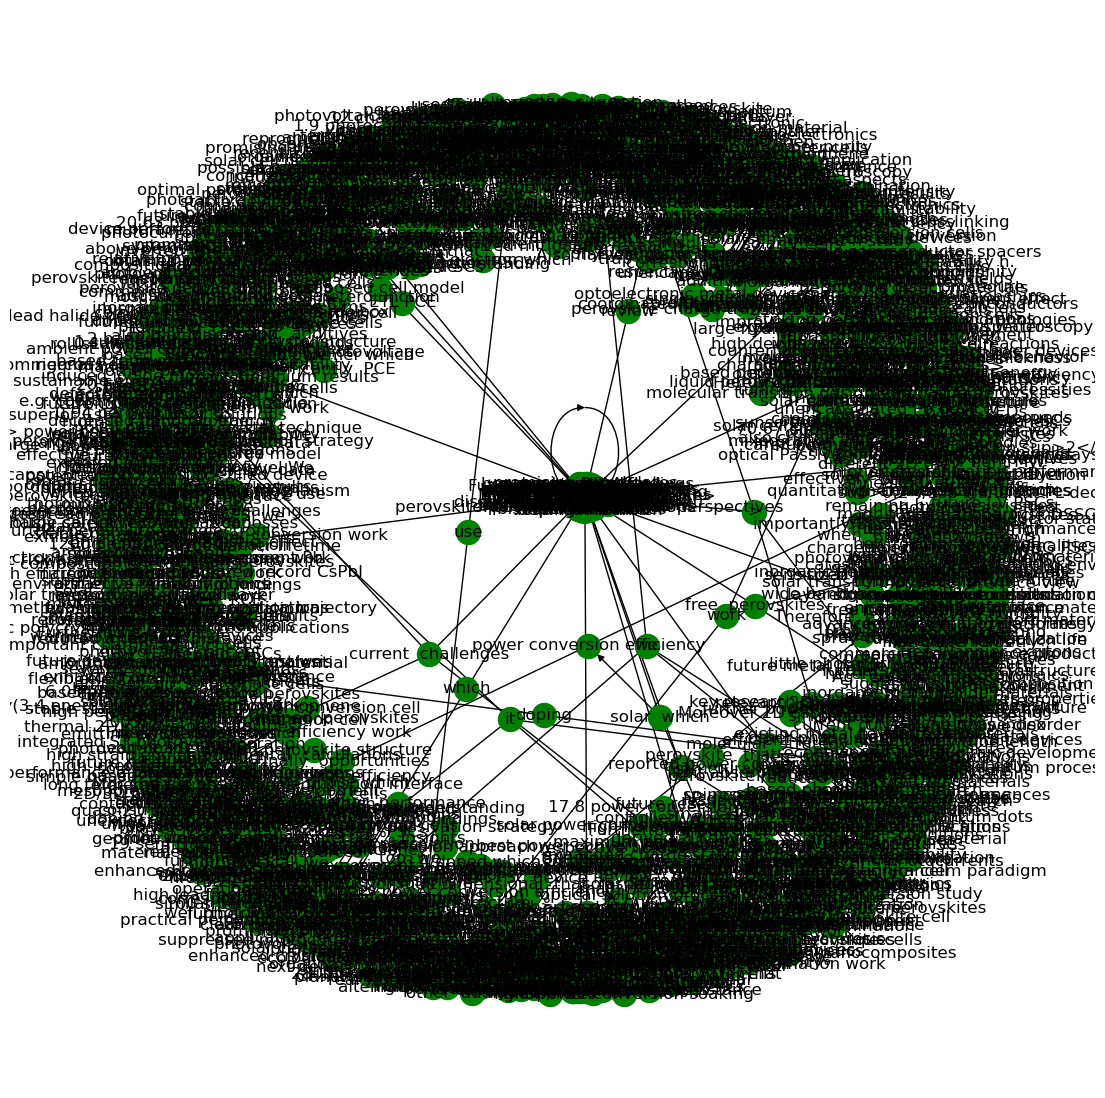

In [26]:
import matplotlib.pyplot as plt
import networkx as nx

# Create DG from the dataframe
graph = nx.from_pandas_edgelist(data_kgf, "source", "target",
                                edge_attr=True, create_using=nx.MultiDiGraph())

# Plotting the network
fig, ax = plt.subplots(figsize=(14, 14))  # Use subplots to access the Axes object
posn = nx.spring_layout(graph)
nx.draw(graph, with_labels=True, node_color='green', edge_cmap=plt.cm.Blues, pos=posn, ax=ax)
plt.show()


In [27]:
# the above pic is of no use, lets try to make it presentable
!pip install plotly
import plotly.graph_objects as go
import networkx as nx

# Create DG from the dataframe
graph = nx.from_pandas_edgelist(data_kgf, "source", "target",
                                edge_attr=True, create_using=nx.MultiDiGraph())

# Get node positions
posn = nx.spring_layout(graph)

# Create edges
edge_x = []
edge_y = []
for edge in graph.edges():
    x0, y0 = posn[edge[0]]
    x1, y1 = posn[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

# Create nodes
node_x = []
node_y = []
node_text = []
for node in graph.nodes():
    x, y = posn[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

# Create figure
fig = go.Figure()

# Add edges
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    mode='lines',
    line=dict(color='rgb(210,210,210)', width=1),
    hoverinfo='none'
))

# Add nodes
fig.add_trace(go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    marker=dict(symbol='circle-dot',
                size=10,
                color='green',
                line=dict(color='rgb(50,50,50)', width=0.5)),
    hoverinfo='text',
    text=node_text
))

# Configure layout
fig.update_layout(
    title='Network Graph',
    title_x=0.5,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20, l=5, r=5, t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

# Show plot
fig.show()


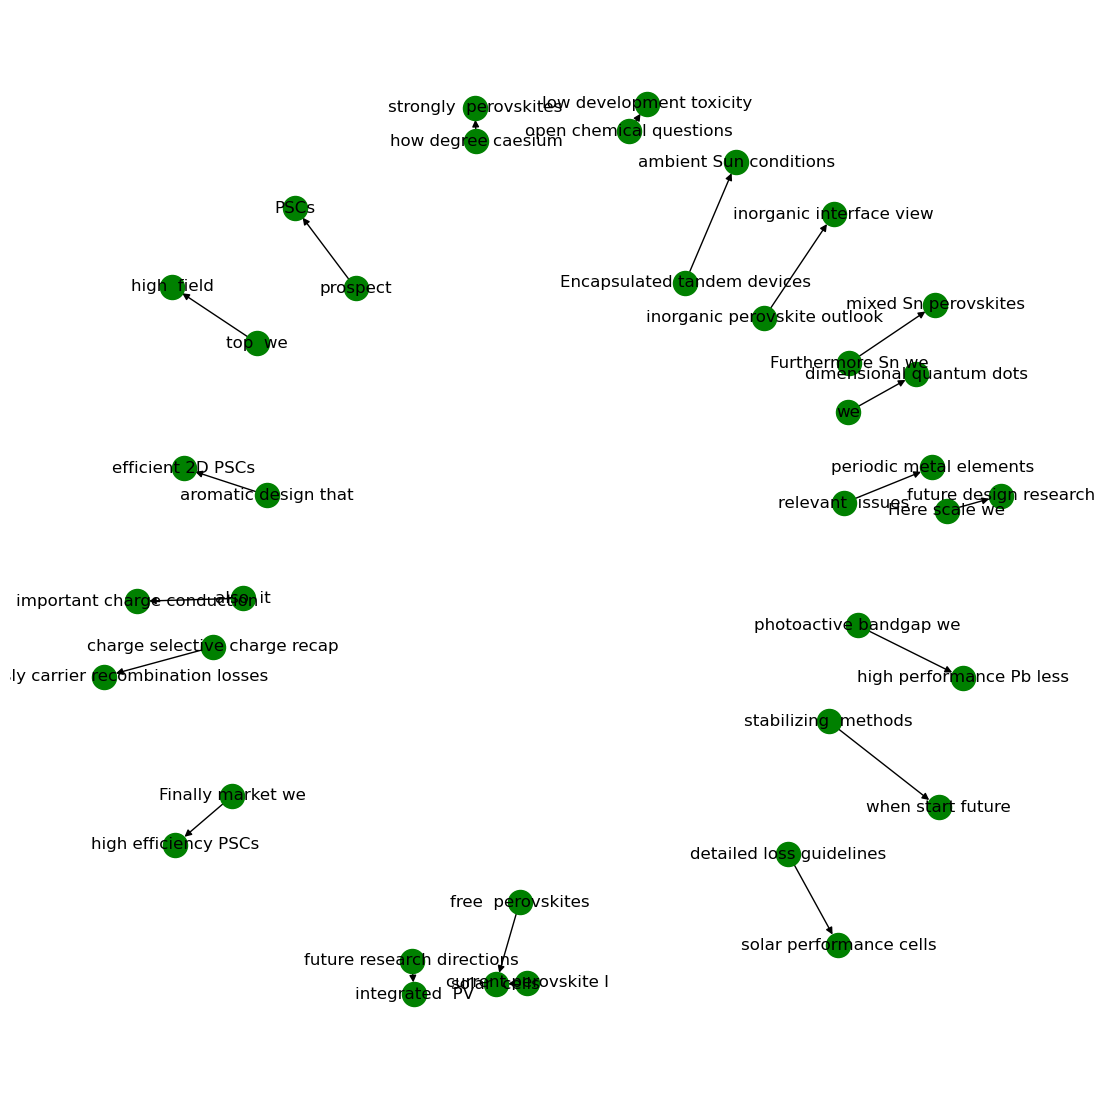

In [54]:
import matplotlib.pyplot as plt
import networkx as nx

selected_data_kgf = data_kgf.head(20)

# Create a directed graph (DiGraph) from the selected DataFrame
graph = nx.from_pandas_edgelist(selected_data_kgf, "source", "target",
                                edge_attr=True, create_using=nx.MultiDiGraph())

# Plotting the network
fig, ax = plt.subplots(figsize=(14, 14))  # Use subplots to access the Axes object
posn = nx.spring_layout(graph)
nx.draw(graph, with_labels=True, node_color='green', edge_cmap=plt.cm.Blues, pos=posn, ax=ax)
plt.show()


In [50]:
import networkx as ntx
import matplotlib.pyplot as plot

graph = ntx.from_pandas_edgelist(data_kgf[data_kgf['edge'] == "Information from"], "source", "target",
                                 edge_attr=True, create_using=ntx.MultiDiGraph())

fig, ax = plot.subplots(figsize=(14, 14))
pos = ntx.spring_layout(graph, k=0.5)  # k regulates the distance between nodes
ntx.draw(graph, with_labels=True, node_color='green', node_size=1400, edge_cmap=plot.cm.Blues, pos=pos, ax=ax)
plot.show()


['node1', 'node2', 'node3']